# Advanced Machine Learning - Project 2
## Mountain Car Problem with Reinforcement Learning

- Eduardo Carneiro - 62515
- Til Dietrich - 62928

# TODO
- review Q-Learning approach and see if it is working properly
- hyper-parameter tuning for Q-Learning (e.g. grid search)
- understand if results from Q-Learn make any sense

- Deep-Q Learning

- Reverb Package does not work on Windows. Thus, im running this notebook in VSCode through a WSL Window
- The next commands create an environment in the WSL with all the necessary packages

In [ ]:
# !sudo apt install python3.10-venv
# !python -m venv venv_AML_linux
# !source venv_AML_linux/bin/activate

In [2]:
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install gymnasium
!pip install seaborn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libice-dev libopengl-dev libsm-dev libxfont2 libxkbfile1
  libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev
  libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev libxfont2
  libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 24 not upgraded.
Ne

In [40]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import seaborn as sns

import pyvirtualdisplay
import PIL

import reverb

import base64
import imageio
import IPython


import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [2]:
sns.set(style='whitegrid', palette='muted', context='paper')

## Table of Contents
### 1. Q-Learning
### 2. Deep-Q Learning

## 1. Q-Learning

In [ ]:
# Implementation based on TP10 notebook
# Still needs checking

In [ ]:
env = gym.make("MountainCar-v0",render_mode='rgb_array')

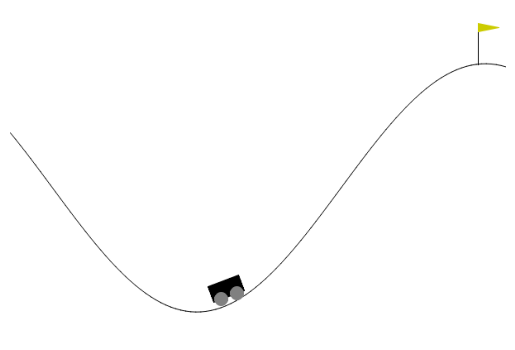

In [ ]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

In [ ]:
print(env.observation_space, env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Discrete(3)


In [ ]:
def discretize(interval, number_batches = -1, batch_percentage = 0.1):

    sum = abs(interval[0]) + abs(interval[1])

    if number_batches != -1:
        batch_size = sum/number_batches
    else:
        batch_size = batch_percentage*sum

    return np.arange(interval[0], interval[1], batch_size)

- P -> Number of discrete positions
- V -> Number of discrete velocities

In [ ]:
# TODO in the end, put all "global" parameters in one cell for easier manipulation ???

In [ ]:
BATCH_PERC = 0.01

position_batches = discretize((env.observation_space.low[0],env.observation_space.high[0]), batch_percentage=BATCH_PERC)
P = len(position_batches)

velocity_batches = discretize((env.observation_space.low[1],env.observation_space.high[1]), batch_percentage=BATCH_PERC)
V = len(velocity_batches)

print(P, position_batches)
print(V, velocity_batches)

100 [-1.20000005 -1.18200005 -1.16400005 -1.14600005 -1.12800004 -1.11000004
 -1.09200004 -1.07400004 -1.05600004 -1.03800004 -1.02000004 -1.00200004
 -0.98400004 -0.96600004 -0.94800004 -0.93000004 -0.91200004 -0.89400004
 -0.87600003 -0.85800003 -0.84000003 -0.82200003 -0.80400003 -0.78600003
 -0.76800003 -0.75000003 -0.73200003 -0.71400003 -0.69600003 -0.67800003
 -0.66000003 -0.64200003 -0.62400002 -0.60600002 -0.58800002 -0.57000002
 -0.55200002 -0.53400002 -0.51600002 -0.49800002 -0.48000002 -0.46200002
 -0.44400002 -0.42600002 -0.40800002 -0.39000002 -0.37200001 -0.35400001
 -0.33600001 -0.31800001 -0.30000001 -0.28200001 -0.26400001 -0.24600001
 -0.22800001 -0.21000001 -0.19200001 -0.17400001 -0.15600001 -0.13800001
 -0.12       -0.102      -0.084      -0.066      -0.048      -0.03
 -0.012       0.006       0.024       0.042       0.06        0.078
  0.096       0.114       0.13200001  0.15000001  0.16800001  0.18600001
  0.20400001  0.22200001  0.24000001  0.25800001  0.276000

In [ ]:
def get_index_position_batch(position):

    l = len(position_batches)

    for low in range(l):

        if position < position_batches[low]:
            return low-1

    return l-1

def get_index_velocity_batch(velocity):

    l = len(position_batches)

    for low in range(l):

        if velocity < position_batches[low]:
            return low-1

    return l-1

In [ ]:
q_table = np.zeros((P, V, env.action_space.n))
print(q_table.shape)

(100, 100, 3)


In [ ]:
def epsilon_greedy(state, epsilon):
    global q_table

    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        # assuming state is a tuple with (position, velocity)
        return np.argmax(q_table[state[0], state[1], :])

### Hyperparameters

In [ ]:
#hyperparameters
alpha = 0.8 #learning rate
gamma = 0.95
epsilon = 0.1
num_episodes = 10001
num_steps = 1000

### Training the agent

In [ ]:

# grid search
# for alpha in [0.7, 0.8, 0.9]:
#     for gamma in [0.85, 0.9, 0.95]:
#         for epsilon in [0.05, 0.1, 0.15]:

arr_total_rewards = []
arr_steps = []
arr_done = np.zeros(num_episodes)

# Q-Learning Algorithm
# for each episode:
for i in range(num_episodes):

    #initialize the state by resetting the environment
    s,_ = env.reset()
    total_reward = 0
    steps = 0

    # discretize
    s = [get_index_position_batch(s[0]), get_index_velocity_batch(s[1])]

    #for each step in the episode
    for t in range(num_steps):

        #select the action using the epsilon-greedy policy
        a = epsilon_greedy(s,epsilon)

        #perform the selected action and store the next state information
        s_, r, done, _, _ = env.step(a)

        # discretize
        s_ = [get_index_position_batch(s_[0]), get_index_velocity_batch(s_[1])]

        #first, select the action a dash which has a maximum Q value in the next state
        v_opt = np.argmax(q_table[s_[0], s_[1], :])

        # we calculate the Q value of previous state using our update rule
        q_table[s[0], s[1], a] = q_table[s[0], s[1], a] + alpha * (r + gamma * (v_opt) - q_table[s[0], s[1], a])

        #update current state to next state
        s = s_

        #info
        total_reward += r
        steps += 1

        #if the current state is the terminal state then break
        if done:
            steps = t
            arr_done[i] = 1
            break

    arr_total_rewards.append(total_reward)
    arr_steps.append(steps)

    if(i%1000 == 0):
        print(f"Episode {i} | Total Reward {total_reward} | Steps {steps}")

-440.0


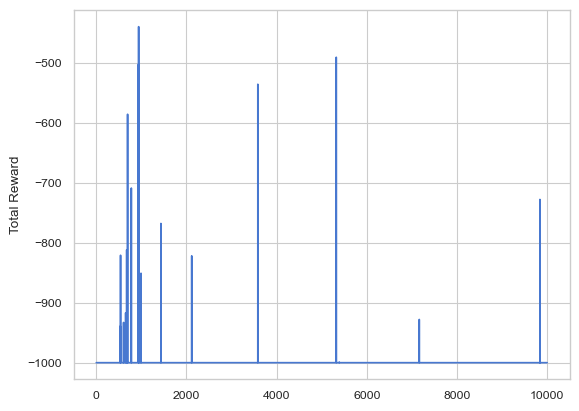

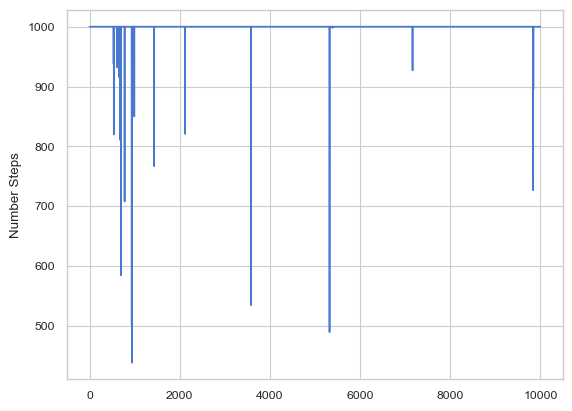

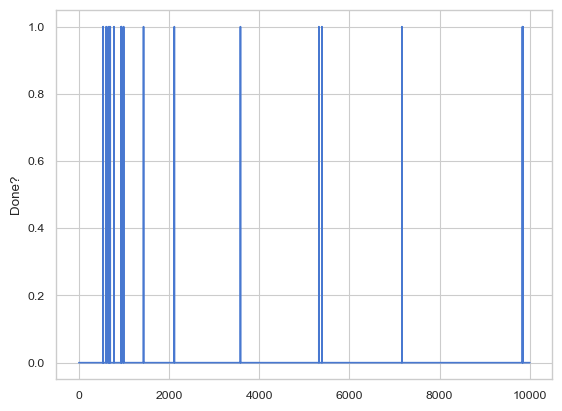

In [ ]:
print(max(arr_total_rewards))

plt.ylabel("Total Reward")
plt.plot(range(0,num_episodes),arr_total_rewards)
plt.show()

plt.ylabel("Number Steps")
plt.plot(range(0,num_episodes),arr_steps)
plt.show()

plt.ylabel("Done?")
plt.plot(range(0,num_episodes),arr_done)
plt.show()

In [ ]:
# Get the optimal policy
# print(q_table)
optimal_policy = np.zeros((P,V))
for pos in range(P):
    for vel in range(V):
        optimal_policy[pos,vel] = np.argmax(q_table[pos, vel, :])

print(optimal_policy)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 2. Deep-Q Learning

- Following [the tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial?hl=en#introduction) and comparing with TP8 notebook, to understand what I'm doing

In [43]:
# not working ?!
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


### Hyperparameters

In [62]:
dqn_layer_params = (15,20) # Layer_1: 4 units | Layer_2: 5 units
learning_rate = 1e-3
num_episodes = 20
num_iterations = 30001
collect_steps_per_iteration = 1
initial_collect_steps = 100

eval_interval = 500
log_interval = 500

replay_buffer_max_length = 100000
batch_size = 64

### Env

In [63]:
env_name = "MountainCar-v0"
env_dqn = suite_gym.load(env_name)
env_dqn.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.48445743,  0.        ], dtype=float32)})

In [ ]:
PIL.Image.fromarray(env_dqn.render())

In [48]:
print('Observation Space:')
print(env_dqn.time_step_spec().observation)


print('Action Space:')
print(env_dqn.action_spec())


Observation Space:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])
Action Space:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


### Environments
- written in python, need to be converted to tensorflow environments

In [64]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [65]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agents

#### Layer Funcs

In [66]:
def dense_layer(num_units, name= ""):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      name= name)

In [67]:
action_tensor_spec = tensor_spec.from_spec(env_dqn.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# hidden layers
dense_layers = [dense_layer(num_unit, f"Layer_{i}") for num_unit,i in zip(dqn_layer_params, range(len(dqn_layer_params)))]

# last layer, with results
q_value_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    name = "q_layer")

q_net = sequential.Sequential(dense_layers + [q_value_layer])

### Creating an Agent

In [68]:
# choosing an optimizer, inputing the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# step counter
train_step_counter = tf.Variable(0)

# create the agent object, feeding it with
# observation and action space,
# the network architecture,
# the choosen optimizer and a loss function (TODO we might test multiple?)
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


### Policies

In [69]:
# ?!?!??!
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [70]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


### Buffer

In [71]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


### Training the agent

In [72]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


- Totally need do review this code below, i still don't understand the buffer
- Just copied it to see if it runs on colab!!

In [73]:
py_driver.PyDriver(
    env_dqn,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())


(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-5.6820410e-01,  1.2172861e-04], dtype=float32)}),
 ())

In [74]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


In [75]:
# print(replay_buffer)
# print(dataset)
iterator = iter(dataset)
print(iterator)

In [77]:
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_episodes)
returns = [avg_return]
losses = []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_dqn,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  losses.append(train_loss)
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)


step = 1000: loss = 1.044177770614624
step = 1000: Average Return = -200.0
step = 1500: loss = 1.2327131032943726
step = 1500: Average Return = -200.0
step = 2000: loss = 11.152852058410645
step = 2000: Average Return = -200.0
step = 2500: loss = 10.812211990356445
step = 2500: Average Return = -200.0
step = 3000: loss = 329.6382141113281
step = 3000: Average Return = -200.0
step = 3500: loss = 1.521298885345459
step = 3500: Average Return = -200.0
step = 4000: loss = 1.4330824613571167
step = 4000: Average Return = -200.0
step = 4500: loss = 163.50643920898438
step = 4500: Average Return = -200.0
step = 5000: loss = 248.3502655029297
step = 5000: Average Return = -200.0
step = 5500: loss = 2.789686441421509
step = 5500: Average Return = -200.0
step = 6000: loss = 1.6122140884399414
step = 6000: Average Return = -200.0
step = 6500: loss = 196.21742248535156
step = 6500: Average Return = -200.0
step = 7000: loss = 2.713010787963867
step = 7000: Average Return = -200.0
step = 7500: loss 

- WHY THE HELL IS THIS GIVING ALWAYS THE SAME RETURN !?!?!?!?

### Plots

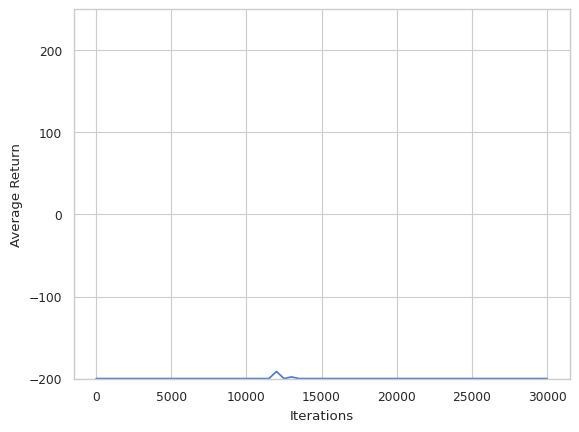

(-74.36055801808834, 250.0)

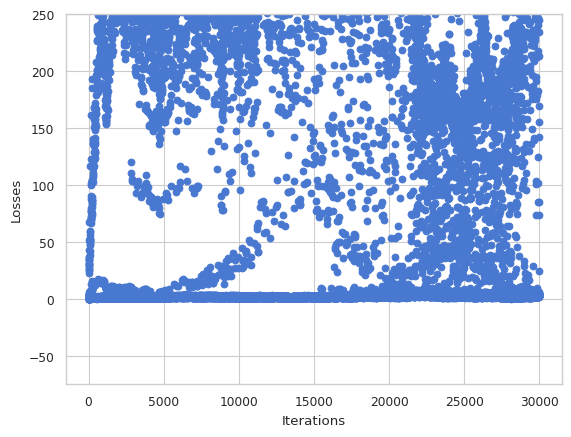

In [84]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)
plt.show()

iterations_log = range(0, num_iterations)
plt.scatter(iterations_log, losses)
plt.ylabel('Losses')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

In [41]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)


In [44]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")


In [45]:
create_policy_eval_video(random_policy, "random-agent")
